<center>
<img src="../logo.png" height="900"> 
</center>


#  Временные ряды

__Тут выражается благодарность [Сергееву Дмитрию](https://github.com/DmitrySerg) за помощь в создании материалов.__ 


Московские диаметры на самом деле не диаметры, а временные ряды на самом деле не ряды. 

> Временной ряд – это последовательность случайных величин, измеренных в последовательные моменты времени, обычно через равные промежутки

In [1]:
import numpy as np
import pandas as pd

from scipy import stats 

import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

import seaborn as sns

%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings('ignore')

# 1. Данные 

Работать будем с просмотрами рекламы. Данные будут часовыми.

In [3]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time']).asfreq('H')
print(ads.shape)
ads.head()

(216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [4]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(15, 6))
y = ads.Ads/10**3  # в тысячах :)

plot_series(y)
plt.title('Просмотры рекламы (тыс. часов)', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);

# 2. Метрики качества прогноза

Рассмотрим основные и самые распространенные метрики качества прогнозов, которые, по большому счету, являются метриками для задачи регрессии и используются далеко не только во временных рядах.


- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), интерпретируемая метрика, измеряется в тех же единицах, что и исходный ряд, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error), также интерпретируемая метрика, однако её преимущество - нечувствительность (робастность) к выбросам в данных, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), используется в большинстве случаев, сильнее наказывает модель за большие ошибки и меньше - за маленькие (парабола), $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), практически тоже самое, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error, как MAE, только в процентах, - удобно для объяснения заказчику качества прогноза, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```
---
- [Mean absolute scaled error](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error), аналог $R^2$ для временных рядов. Тоже сравнивает прогноз по вашей модели с наивным и говорит насколько он оказался лучше.

Мы будем ниже пользоваться MAPE.

In [5]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 3. Библиотеки

С библиотеками для временных рядов дело обстоит не очень хорошо. Их довольно много и они мелкие. Нет большой общей библиотеки вроде sklearn, которая могла бы предоставить общий удобный интерфейс для работы. 

Однако совсем недавно начали создавать свежую библиотеку  [sktime,](https://www.sktime.org/en/latest/) которая развивается как раз в парадигме sklearn. Она совместима со sklearn, умеет строить предиктивные интервалы и автоматически перебирать модели. Также в ней можно строить ансамбли. Её мы и попробуем использовать.

Библиотеку нужно поставить через pip: `pip3 install sktime`. Подробную инструкцию по установке [ищите в документации.](https://www.sktime.org/en/latest/installation.html) Библиотека statsmodels должна быть версии 0.12.0 и выше. Обратите внимание, что определённые кусочки моделей могут быть нереализованы. Вы можете реализовать их сами на python и принять участие в создании библиотеки.

Библиотека включает в себя возможности `statsmodels` и `pmdarima`. Если вам хочется попробовать какие-то другие библиотеки, [на вот этой страничке](https://github.com/MaxBenChrist/awesome_time_series_in_python) есть довольно удобный список. Из него довольно интересно выглядит библиотека `prophet` от facebook

In [6]:
import statsmodels
print(statsmodels.__version__)

0.14.2


In [7]:
import sktime
print(sktime.__version__)

0.37.0


Разбиение данных на обучение и контроль.

In [8]:
y.size // 24

9

In [9]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=48)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

168 48


Чтобы прогнозы корректно индексировались, заведём отдельную переменную с индексами-датами. 

In [10]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2017-09-20 00:00:00', '2017-09-20 01:00:00',
               '2017-09-20 02:00:00', '2017-09-20 03:00:00',
               '2017-09-20 04:00:00', '2017-09-20 05:00:00',
               '2017-09-20 06:00:00', '2017-09-20 07:00:00',
               '2017-09-20 08:00:00', '2017-09-20 09:00:00',
               '2017-09-20 10:00:00', '2017-09-20 11:00:00',
               '2017-09-20 12:00:00', '2017-09-20 13:00:00',
               '2017-09-20 14:00:00', '2017-09-20 15:00:00',
               '2017-09-20 16:00:00', '2017-09-20 17:00:00',
               '2017-09-20 18:00:00', '2017-09-20 19:00:00',
               '2017-09-20 20:00:00', '2017-09-20 21:00:00',
               '2017-09-20 22:00:00', '2017-09-20 23:00:00',
               '2017-09-21 00:00:00', '2017-09-21 01:00:00',
               '2017-09-21 02:00:00', '2017-09-21 03:00:00',
               '2017-09-21 04:00:00', '2017-09-21 05:00:00',
               '2017-09-21 06:00:00', '2017-09-21 07:00:00',
               '201

# 4. Наивный прогноз

Можно построить наивный прогноз с помощью разных стратегий. Например, как последнее значение. 

In [11]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [12]:
mape(y_pred, y_test)

47.78000294352635

Либо среднего за последние `window_length` наблюдений. 

In [13]:
forecaster = NaiveForecaster(strategy="mean", window_length=48)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [14]:
mape(y_pred, y_test)

19.02365319048165

Можно с помощью сезонного последнего значения.

In [15]:
forecaster = NaiveForecaster(strategy="last", sp=24)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [16]:
mape(y_pred, y_test)

4.170703497277533

Самый лучший из наивных прогнозов, в виде последнего сезонного значения, мы и будем использовать в качестве базового решения. Обратите внимание, что если бы модель содержала тренд, было бы логично как-то учесть его в вашем наивном прогнозе. Иначе любая модель будет его превосходить по качеству, что не очень честно. 

# 5. ETS - модели 

### ETS(ANN)

In [17]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# ETS(ANN)   старое название: Simple exponential smoothing
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [18]:
mape(y_test, y_pred)

29.316225597326962

In [19]:
forecaster.get_fitted_params()

{'initial_level': 77.85072200520828,
 'initial_slope': None,
 'initial_seasons': array([], dtype=float64),
 'aic': 835.9341340282649,
 'bic': 842.1820619870714,
 'aicc': 836.1795328012711}

Если попросить интервальные прогнозы, пакет скажет, что они не реализованы. Вы знаете как их сделать и можете попробовать реализовать для этого пакета на базе statsmodels. Как строить интервальные прогнозы в нём, мы посмотрим ниже.

### ETS(AAA)

In [24]:
# ETS(ANN)   старое название: Simple exponential smoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="add", sp=24)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ads'>)

In [22]:
mape(y_test, y_pred)

4.2265347888018745

In [ ]:
forecaster.get_fitted_params()

{'initial_level': 80.66577867694073,
 'initial_slope': None,
 'initial_seasons': array([-0.51439791, -1.88268478,  5.06372944, 16.98127147, 37.50726009,
        36.91750499, 33.39777296, 31.2778113 , 32.56089178, 35.45478882,
        47.60980212, 62.26394383, 70.88526791, 67.62135501, 68.40858758,
        67.53938742, 67.75185845, 70.30551097, 77.79805318, 77.2860034 ,
        52.72110656, 27.7796507 , 14.21593219,  2.21877498]),
 'smoothing_level': 0.9999999850988388,
 'smoothing_slope': None,
 'smoothing_seasonal': 1.6009681010784822e-10,
 'damping_slope': None}

### Auto-ETS

Можно перебрать все ETS модели и выбрать лучшую по какому-то критерию. 

In [25]:
from sktime.forecasting.ets import AutoETS

# Делаем перебор и выбираем лучшую модель по информационному критерию
forecaster = AutoETS(auto=True, n_jobs=-1, information_criterion='bic')
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [26]:
mape(y_test, y_pred)

71.62216025800235

### Доверительные интервалы

К сожалению, в рамках `sktime` доверительные интервалы для ETS-моделей ещё не реализованы. Вы можете помочь развитию пакета и [реализовать их самостоятельно! :)](https://github.com/alan-turing-institute/sktime/issues) 

Сейчас ETS-модель опирается в этом пакете на модуль `exponential_smoothing` из пакета `statsmodels`. В нём доверительные интервалы не предусмотрены. В этом же пакете есть модуль `statespace`. Там доверительные интервалы уже есть. 

In [ ]:
import statsmodels.api as sm

ets_aaa = sm.tsa.statespace.ExponentialSmoothing(y_train, trend=True, seasonal=24)
ets_aaa_res = ets_aaa.fit()
print(ets_aaa_res.summary())

NameError: name 'y_train' is not defined

In [ ]:
h = 48 # test_size
df_forecast = ets_aaa_res.get_forecast(h).summary_frame()
df_forecast.index = fh
df_forecast.head()

Ads,mean,mean_se,mean_ci_lower,mean_ci_upper
2017-09-20 00:00:00,76.508850,5.291217,66.138256,86.879444
2017-09-20 01:00:00,75.107132,7.482911,60.440897,89.773367
2017-09-20 02:00:00,82.013386,9.164962,64.050391,99.976381
2017-09-20 03:00:00,93.881254,10.583227,73.138509,114.623998
2017-09-20 04:00:00,114.355416,11.832940,91.163279,137.547552


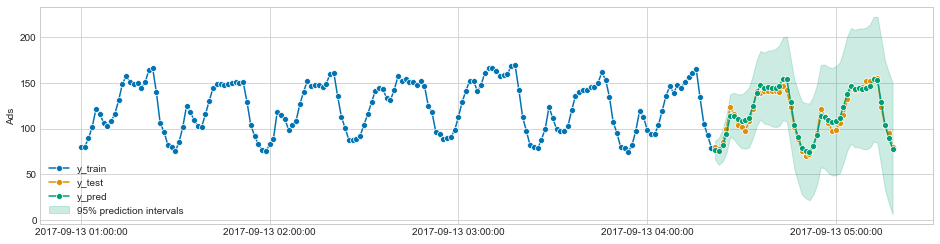

In [ ]:
fig, ax = plot_series(y_train, y_test, df_forecast['mean'], labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["mean_ci_lower"],
    df_forecast["mean_ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');

In [ ]:
mape(y_test, df_forecast['mean'])

4.199859644314157

## Диагностика модели

Чтобы доверительный интервалы были корректными, надо чтобы выполнялись предпосылки модели. Ошибки должны быть независимо нормально распределены с нулевым средним и одинаковой дисперсией. Давайте посмотрим на них. 

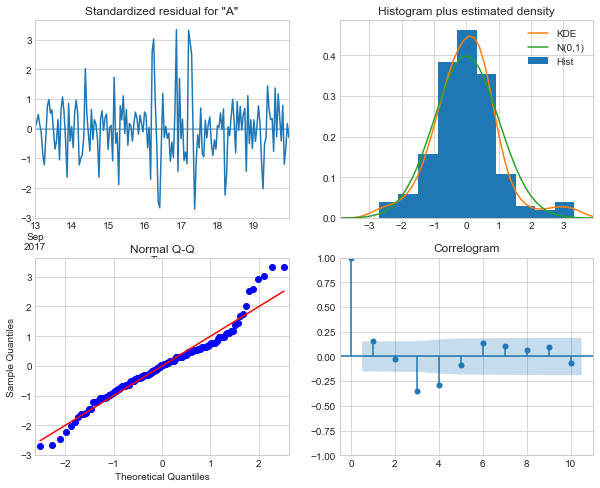

In [ ]:
ets_aaa_res.plot_diagnostics(figsize=(10, 8));

- Левый верхний график показывает динамику остатков во времени вокруг среднего. Мы видим, что математическое ожидание действительно совпадает с нулём. С дисперсией также всё в норме. 

- Правый нижний график называется коррелелограмма. По данным считается автокорреляция $Corr(u_t, u_{t-s})$. Голубым нарисован доверительный интервал для этих корреляций. Если корреляция лежит внутри интервала, гипотеза о её равенстве нулю не отвергается. Судя по всему $Corr(u_t, u_{t-3})$ и $Corr(u_t, u_{t-4})$ ненулевые. Это может быть связано с тем, что мы некорректно задали параметры, которые отвечают за сезонность.

- На второстепенной диагонали находится распределение остатков и диаграмма квантиль-квантиль. Хвосты распределения оказываются тяжёлыми. 

Выполнения предпосылок модели можно попытаться добиться, поперебирав гиперпараметры модели. Либо можно попробовать сделать остатки более похожими на нормальные, сделав для исходного ряда преобразование Бокса-Кокса. 

Если нас не интересуют интервальные прогнозы, а интересуют только точечные, можно не добавиваться выполнения предпосылки о нормальности. Также можно заменить нормальное распределение ошибок на какое-то другое и заняться максимизацией своей собственной функции правдоподобия. Правда придётся реализовать её вручную по аналогии с тем, что мы делали на неделе про правдоподобие. 

# 6. Кросс-валидация

Выше мы оценивали модель на тренировочном периоде, а дальше строили прогноз на весь тестовый. Дальше мы считали ошибку. Это не очень корректно, так как строить прогноз на неделю вперёд сложнее, чем на сутки вперёд. 

Гораздо корректнее сделать кросс-валидацию со скользящим окном и сравнить модели между собой на разных горизонтах прогнозирования. 

In [36]:
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

Посмотрим в документацию. Там пишут, что размер тренировочных выборок на $i$-ой итерации:  

``i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1)`` 

Размер тестовой выборки на $i$-ой итерации: 

``n_samples//(n_splits + 1)``

In [32]:
z = np.arange(10)

tscv = TimeSeriesSplit(n_splits=3) #, max_train_size=5)

for train_index, test_index in tscv.split(z):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [0 1 2 3] TEST: [4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]


Настроим разбиение так, чтобы в тесте всегда было 7 наблюдений.

In [33]:
n_samples = y.size
n_splits = y.size // 8

# начинаем строить модель с 27 наблюдения
n_samples // (n_splits + 1) + n_samples % (n_splits + 1)

27

In [34]:
# в тесте каждый раз по 7 наблюдений
n_samples//(n_splits + 1)

7

In [39]:
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=27, test_size=None)

In [40]:
from collections import defaultdict

n_splits = y.size // 8          # для того, чтобы в тесте каждый раз было 7 наблюдений
h = n_samples//(n_splits + 1)   # число наблюдений в тестовой выборке 

M = defaultdict(list) # для метрик

def mape(y_true, y_pred): 
    return np.abs((y_true - y_pred) / y_true)* 100

tscv = TimeSeriesSplit(n_splits=n_splits) 
for train, test in tscv.split(y):
    y_tr, y_ts = y[train].values, y[test].values
    
    # Первая модель
    model = sm.tsa.statespace.ExponentialSmoothing(y_tr, trend=True, seasonal=48).fit()
    y_hat = model.get_forecast(h).summary_frame()['mean']
    M['ETS(A A A)'].append(mape(y_ts, y_hat.values))
    
    # Вторая модель
    model = sm.tsa.statespace.ExponentialSmoothing(y_tr, trend=True, seasonal=24, damped_trend=True).fit()
    y_hat = model.get_forecast(h).summary_frame()['mean']
    M['ETS(A Ad A)'].append(mape(y_ts, y_hat.values))

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_32112\2578293843.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_tr, y_ts = y[train].values, y[test].values


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [41]:
# Ошибки при кросс-валидации из текущей точки на 7 дней вперёд
np.array(M['ETS(A A A)'])

array([], dtype=float64)

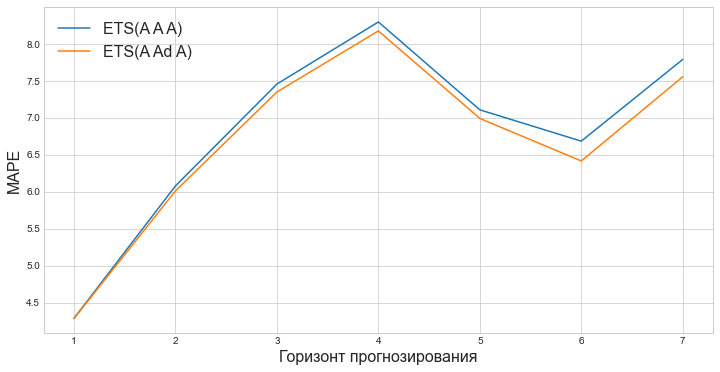

In [ ]:
plt.figure(figsize=(12,6))
for m in M.keys():
    plt.plot(np.arange(1,h+1),np.array(M[m]).mean(axis=0), label=m)
    
plt.xlabel('Горизонт прогнозирования', fontsize=16)
plt.ylabel('MAPE', fontsize=16)
plt.legend(fontsize=16);

Видно, что на $1-2$ дня модели прогнозируют примерно одинаково, а дальше качество расходится. 

# 7. LOO кросс-валидация

LOO кросс-валидацию можно сделать более элегантно, с помощью оконных функций в `pandas`.

In [ ]:
def timeseries_cv(y, metric=mape, treshhold=0.8):
    
    # последний день всегда в тестовой выборке
    y_train = y[:-1].values
    y_test = y[-1:].values
    
    # на каждой выборке обучаем модель
    model = sm.tsa.statespace.ExponentialSmoothing(y_train, trend=True, seasonal=24)
    res = model.fit()
    
    # делаем прогноз и находим качество прогноза
    y_hat = res.get_forecast(1).summary_frame()['mean']
    return metric(y_test, y_hat)

Функция прогнозирует на день вперёд и вычисляет ошибку. 

In [ ]:
timeseries_cv(y)

0    3.548377
Name: mean, dtype: float64

Воспользуемся методами `expanding` и `rolling`.

![](./expanding&rolling.jpeg) 

In [ ]:
min_period = int(0.8*y.size)

In [ ]:
# расширяющееся окно
quality = y.expanding(min_period).apply(lambda x: timeseries_cv(x))
quality.dropna().mean()

3.2075568859543044

In [ ]:
# скользящее окно
quality = y.rolling(min_period).apply(lambda x: timeseries_cv(x))
quality.dropna().mean()

3.620411372451665